In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

## Aleatoric homoskedastic model

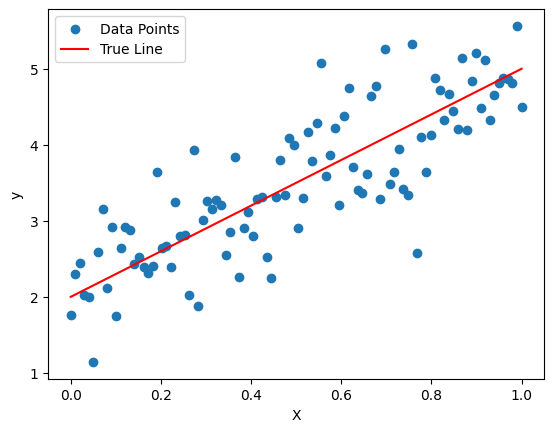

In [109]:
# Generate the dataset
slope = 3
intercept = 2
N = 100
X = np.linspace(0, 1, N)
true_sigma = 0.5
noise = np.random.normal(0, true_sigma, N)
y = slope * X + intercept + noise
plt.scatter(X, y)
plt.plot(X, slope * X + intercept, 'r')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(['Data Points', 'True Line'])
plt.show()

In [110]:
# We have three parameters: slope, intercept, and sigma(std of noise)
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Define the forward pass
def forward(X, slope, intercept, sigma):
    return slope * X + intercept + torch.distributions.Normal(0, sigma).sample(X.shape)

# define the loss function
def nll(theta, sigma,  X, y):   #theta = [intercept, slope]
    mu = theta[0] + theta[1] * X
    dist = torch.distributions.normal.Normal(mu, sigma)
    return y.shape[0]*torch.log(sigma) + (0.5) * torch.sum( (y - mu)**2 ) / (sigma**2)


# initialize the parameters
theta0 = torch.tensor(0.0, requires_grad=True)
theta1 = torch.tensor(0.0, requires_grad=True)
sigma = torch.tensor(0.1, requires_grad=True)

# Define optimizer
optimizer = optim.Adam([theta0, theta1, sigma], lr=0.01)
num_epochs = 1000

# Gradient descent
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = nll([theta0, theta1], sigma, X, y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch {}, Loss {}'.format(epoch, loss.item()))

print('Final parameters: slope {}, intercept {}, sigma {}'.format(theta1.item(), theta0.item(), sigma.item()))
print("--------------------------------------------")
# Print the final parameters
final_params = {"intercept": theta0.item(), "slope": theta1.item(), "sigma": sigma.item()}
true_params = {"intercept": intercept, "slope": slope, "sigma": true_sigma }

df = pd.DataFrame([final_params, true_params], index=['Learnt', 'True'])
print(df)

Epoch 0, Loss 66134.8515625
Epoch 100, Loss 3044.65966796875
Epoch 200, Loss 1580.97119140625
Epoch 300, Loss 952.7923583984375
Epoch 400, Loss 609.8676147460938
Epoch 500, Loss 400.1264953613281
Epoch 600, Loss 263.926025390625
Epoch 700, Loss 172.70840454101562
Epoch 800, Loss 110.84466552734375
Epoch 900, Loss 68.90113830566406
Final parameters: slope 2.006838798522949, intercept 1.966152548789978, sigma 0.5846088528633118
--------------------------------------------
        intercept     slope     sigma
Learnt   1.966153  2.006839  0.584609
True     2.000000  3.000000  0.500000


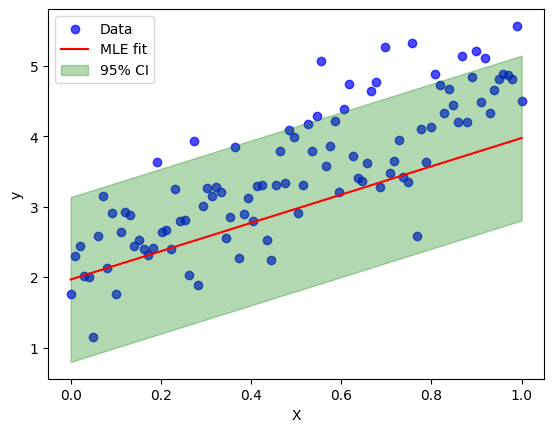

In [111]:
# Plot the final line + confidence interval
plt.scatter(X, y, label='Data', color='blue', alpha=0.7)
plt.plot(X, theta1.item() * X + theta0.item(), label='MLE fit', color='red')
plt.fill_between(X, theta1.item() * X + theta0.item() + 2 * sigma.item(), theta1.item() * X + theta0.item() - 2 * sigma.item(), 
                 label='95% CI', color='green', alpha=0.3)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## Aleatoric Heteroskedastic model

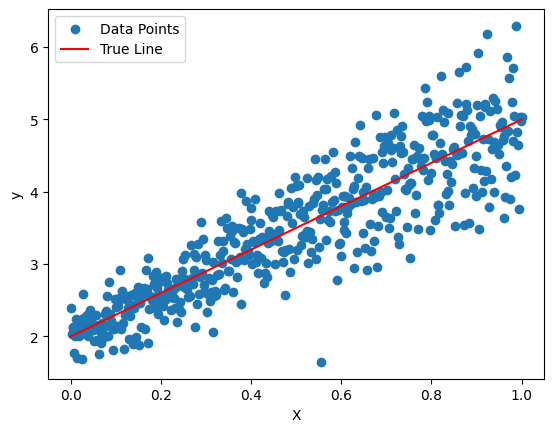

In [98]:
# Generate the dataset
slope = 3
intercept = 2
true_sigma = 0.5 + 0.1 * X.squeeze()  # Varying standard deviation
N = 500
X = np.linspace(0, 1, N)
def noise(x):
    # Define a function that determines the true standard deviation
    std = 0.2 + 0.5 * x.squeeze()
    return np.random.normal(0, std, x.shape)

y = slope * X + intercept + noise(X)
plt.scatter(X, y)
plt.plot(X, slope * X + intercept, 'r')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(['Data Points', 'True Line'])
plt.show()

In [101]:
# We have four parameters: slope, intercept, slope of sigma and intercept of sigma
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# define the loss function
def nll(theta, sigma,  X, y):   #theta = [intercept, slope] , sigma = [intercept_std, slope_std]
    def noise_gen(x):
    # Define a function that determines the standard deviation
        std = sigma[0] + sigma[1] * x.squeeze()
        return np.random.normal(0, std.detach().numpy(), x.shape)
    mu = theta[0] + theta[1] * X + torch.tensor(noise_gen(X), dtype=torch.float32, requires_grad=True)
    std = sigma[0] + sigma[1]* X.squeeze()
    return torch.sum(torch.log(std) + (0.5 * (y - mu) ** 2) / (std ** 2))

# initialize the parameters
theta0 = torch.tensor(0.0, requires_grad=True)
theta1 = torch.tensor(1.0, requires_grad=True)
sigma0 = torch.tensor(0.01, requires_grad=True)
sigma1 = torch.tensor(0.1, requires_grad=True)

# Define optimizer
optimizer = optim.Adam([theta0, theta1, sigma0, sigma1], lr=0.01)
num_epochs = 2000

# Gradient descent
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = nll([theta0, theta1], [sigma0, sigma1], X, y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch {}, Loss {}'.format(epoch, loss.item()))

# Print the final parameters
print('Final parameters: slope {}, intercept {}, sigma_slope {}, sigma_intercept {}'.format(theta1.item(), theta0.item(), 
                                                                  sigma1.item(), sigma0.item()))
print("--------------------------------------------")
final_params = {"intercept": theta0.item(), "slope": theta1.item(), "sigma_intercept": sigma0.item(), "sigma_slope": sigma1.item()}
true_params = {"intercept": intercept, "slope": slope, "sigma_intercept": 0.2, "sigma_slope": 0.5}
df = pd.DataFrame([final_params, true_params], index=['Learnt', 'True'])
print(df)

C:\Users\Hp\AppData\Local\Temp\ipykernel_24860\489021361.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
C:\Users\Hp\AppData\Local\Temp\ipykernel_24860\489021361.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


Epoch 0, Loss 1297722.25
Epoch 100, Loss 26356.43359375
Epoch 200, Loss 15043.6220703125
Epoch 300, Loss 9564.5849609375
Epoch 400, Loss 6541.11767578125
Epoch 500, Loss 4536.67626953125
Epoch 600, Loss 2964.493408203125
Epoch 700, Loss 2114.36767578125
Epoch 800, Loss 1564.985107421875
Epoch 900, Loss 1098.209716796875
Epoch 1000, Loss 728.1107788085938
Epoch 1100, Loss 539.96337890625
Epoch 1200, Loss 345.6755065917969
Epoch 1300, Loss 203.81283569335938
Epoch 1400, Loss 216.44821166992188
Epoch 1500, Loss 162.36334228515625
Epoch 1600, Loss 76.45249938964844
Epoch 1700, Loss 81.35650634765625
Epoch 1800, Loss 89.53985595703125
Epoch 1900, Loss 58.508384704589844
Final parameters: slope 3.364204168319702, intercept 1.8162094354629517, sigma_slope 0.4746312201023102, sigma_intercept 0.2023167908191681
--------------------------------------------
        intercept     slope  sigma_intercept  sigma_slope
Learnt   1.816209  3.364204         0.202317     0.474631
True     2.000000  3.0000

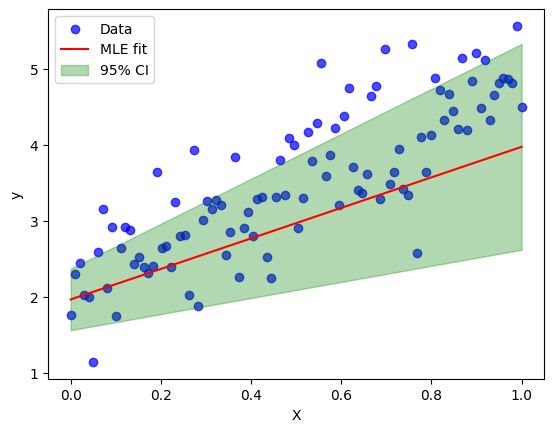

In [112]:
# Plot the final line + confidence interval
plt.scatter(X, y, label='Data', color='blue', alpha=0.7)
plt.plot(X, theta1.item() * X + theta0.item(), label='MLE fit', color='red')
plt.fill_between(X, theta1.item() * X + theta0.item() + 2 * sigma1.item()*X + 2 * sigma0.item(), theta1.item() * X + theta0.item() - 2 * sigma1.item()*X - 2 * sigma0.item(),
                    label='95% CI', color='green', alpha=0.3)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## Using NN: Aleatoric Homoskedastic model

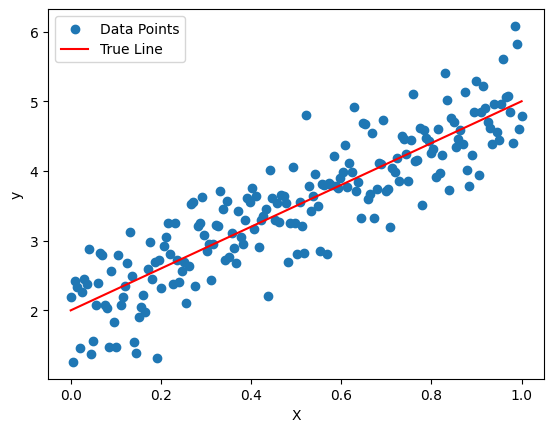

In [152]:
# Using neural network
# create the dataset for homoSk model
slope = 3
intercept = 2
true_sigma = 0.5
N = 200
X = np.linspace(0, 1, N)
noise = torch.distributions.Normal(0, true_sigma).sample(X.shape).detach().numpy()
y = slope * X + intercept + noise
plt.scatter(X, y)
plt.plot(X, slope * X + intercept, 'r')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(['Data Points', 'True Line'])
plt.show()

In [163]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Create the neural network
torch.manual_seed(56)
class AleatoricLR_homoSK(nn.Module):
    def __init__(self):
        super(AleatoricLR_homoSK, self).__init__()
        self.fc1 = nn.Linear(in_features=N, out_features=64)  
        self.fc2 = nn.Linear(64, 32)
        self.fc3= nn.Linear(32, 3) 

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        theta0 = x[0]
        theta1 = x[1]
        std = x[2]
        return theta0, theta1, std
        

model = AleatoricLR_homoSK()

# define the loss function
def nll(theta, sigma,  X, y):   #theta = [intercept, slope]
    mu = theta[0] + theta[1] * X
    # dist = torch.distributions.normal.Normal(mu, sigma)
    return y.shape[0]*torch.log(sigma) + (0.5) * torch.sum( (y - mu)**2 ) / (sigma**2)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    theta0, theta1, std = model(X)
    loss = torch.mean(nll([theta0, theta1], std, X, y))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

# Extract learned parameters
theta0, theta1, std = model(X)

print('Final parameters: slope {}, intercept {}, sigma {}'.format(theta1.item(), theta0.item(), std.item()))
print("--------------------------------------------")
final_params = {"intercept": theta0.item(), "slope": theta1.item(), "sigma": std.item()}
true_params = {"intercept": intercept, "slope": slope, "sigma": true_sigma }
df = pd.DataFrame([final_params, true_params], index=['Learnt', 'True'])
print(df)


C:\Users\Hp\AppData\Local\Temp\ipykernel_24860\2585436701.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
C:\Users\Hp\AppData\Local\Temp\ipykernel_24860\2585436701.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


Epoch [100/1000], Loss: 468.01861572265625
Epoch [200/1000], Loss: 416.9525146484375
Epoch [300/1000], Loss: 239.22842407226562
Epoch [400/1000], Loss: 61.802330017089844
Epoch [500/1000], Loss: -56.66218566894531
Epoch [600/1000], Loss: -56.682037353515625
Epoch [700/1000], Loss: -56.682044982910156
Epoch [800/1000], Loss: -56.68205261230469
Epoch [900/1000], Loss: -56.68205261230469
Epoch [1000/1000], Loss: -56.68206787109375
Final parameters: slope 3.0184497833251953, intercept 1.9897165298461914, sigma 0.4568435251712799
--------------------------------------------
        intercept    slope     sigma
Learnt   1.989717  3.01845  0.456844
True     2.000000  3.00000  0.500000


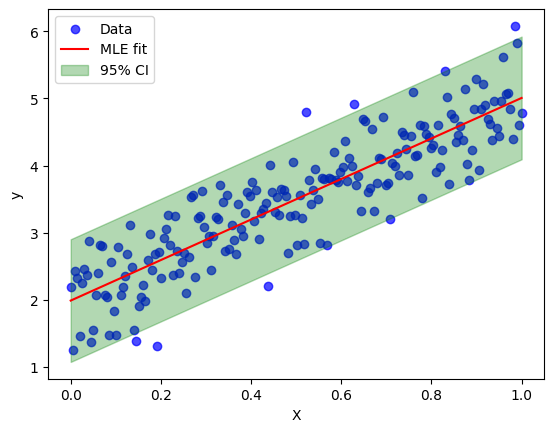

In [164]:
# Plot the final line + confidence interval
plt.scatter(X, y, label='Data', color='blue', alpha=0.7)
plt.plot(X, theta1.item() * X + theta0.item(), label='MLE fit', color='red')
plt.fill_between(X, theta1.item() * X + theta0.item() + 2 * std.item(), theta1.item() * X + theta0.item() - 2 * std.item(),
                    label='95% CI', color='green', alpha=0.3)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()